### PREDICTING MICROBIOME CHANGE IN TIME WITH RANDOM FOREST 


    1. interpolate df using PCHIP interpolation
    2. add pseudocount and change ecah row to 100%
    3. trasform using log transformations: CLR(y) and ALR(X)
    4. filter rare bacteria
    5. fit random forest model and predict bacteria in time: one model per target

In [14]:
#base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

import pickle

from scipy.interpolate import pchip_interpolate
from scipy import interpolate, stats

import skbio
from skbio.stats.composition import clr, alr, alr_inv, ilr, ilr_inv
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

MODULE_PATH = os.path.abspath('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/data-preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit
from interpolation import Interpolation

In [6]:
INPUT_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_no_rarefaction/male_assigned_sample_names.csv'

DF = pd.read_csv(INPUT_FILE, index_col = [0])
DF.index  = DF.index.astype(int)

#interpolate using pchip
interpolator = Interpolation()
INTERPOLATED_DF = interpolator.interpolate_pchip(DF) + 1e-9

#change to PRC
INTERPOLATED_PRC = INTERPOLATED_DF.div(INTERPOLATED_DF.sum(axis=1), axis=0) 

#change to ratio
CLR_DF =  pd.DataFrame(clr(INTERPOLATED_PRC), columns = INTERPOLATED_PRC.columns)

#filter rare bacteria 
processing = MicrobiomeDataPreprocessing()
KEEP_COLUMNS = processing.filter_rare_features(INTERPOLATED_DF, treshold_perc=0.7).columns


FILTERED_CLR_DF = CLR_DF[KEEP_COLUMNS]
FILTERED_COUNT_DF = INTERPOLATED_PRC[KEEP_COLUMNS]

In [9]:
def compositional_random_forest(X, y):
    
    n_estimators = [100, 500, 1000]
    max_features = ['sqrt']
    max_depth = [3, 10, 20] #As you increase max depth you increase variance and decrease bias
    random_state = [42] 

    param_grid = {'n_estimators': n_estimators, 
                 'max_features':max_features,
                 'max_depth':max_depth}

    cv = RepeatedKFold(n_repeats=3,
                       n_splits=3,
                       random_state=1)

    rf_model = RandomForestRegressor(warm_start=True, criterion = 'mae')
    
    rf_grid = GridSearchCV(estimator = rf_model,
                             param_grid = param_grid,
                             cv = cv,
                             verbose=1,
                             n_jobs = -1,
                             scoring = 'r2',
                             refit=True
                            )
    rf_grid.fit(X, y)
    return rf_grid

In [21]:
lag=1

PREDICTION_TEST = pd.DataFrame()
PREDICTION_TRAIN = pd.DataFrame()

for i in range(len(FILTERED_CLR_DF.columns)):
    denom_idx = 0
    denom_name = FILTERED_COUNT_DF.iloc[:, denom_idx].name
    COLS = FILTERED_COUNT_DF.drop(columns=denom_name, axis=1).columns

    FILTERED_ALR_DF = pd.DataFrame(alr(FILTERED_COUNT_DF, denom_idx), columns = COLS)

    processing = MicrobiomeDataPreprocessing()
    CLR_SUPERVISED_DF = processing.make_supervised(FILTERED_CLR_DF, lag).filter(like='lag0')
    ALR_SUPERVISED_DF = processing.make_supervised(FILTERED_ALR_DF, lag)
    ALR_SUPERVISED_DF = ALR_SUPERVISED_DF.drop(columns = ALR_SUPERVISED_DF.filter(like='lag0').columns)

    X_train = ALR_SUPERVISED_DF[:-40]
    X_test = ALR_SUPERVISED_DF[-40:]

    y_train = CLR_SUPERVISED_DF[:-40].iloc[:, denom_idx]
    y_test = CLR_SUPERVISED_DF[-40:].iloc[:, denom_idx]

    model = compositional_random_forest(X_train, y_train)

    prediction_train = model.predict(X_train)
    prediction_test  = model.predict(X_test)
    denom_name = FILTERED_COUNT_DF.iloc[:, i].name

    PREDICTION_TRAIN[denom_name] = prediction_train 
    PREDICTION_TEST[denom_name] = prediction_test

Fitting 2 folds for each of 1 candidates, totalling 2 fits


Text(0.5, 1.0, "model's performance on train and test sets")

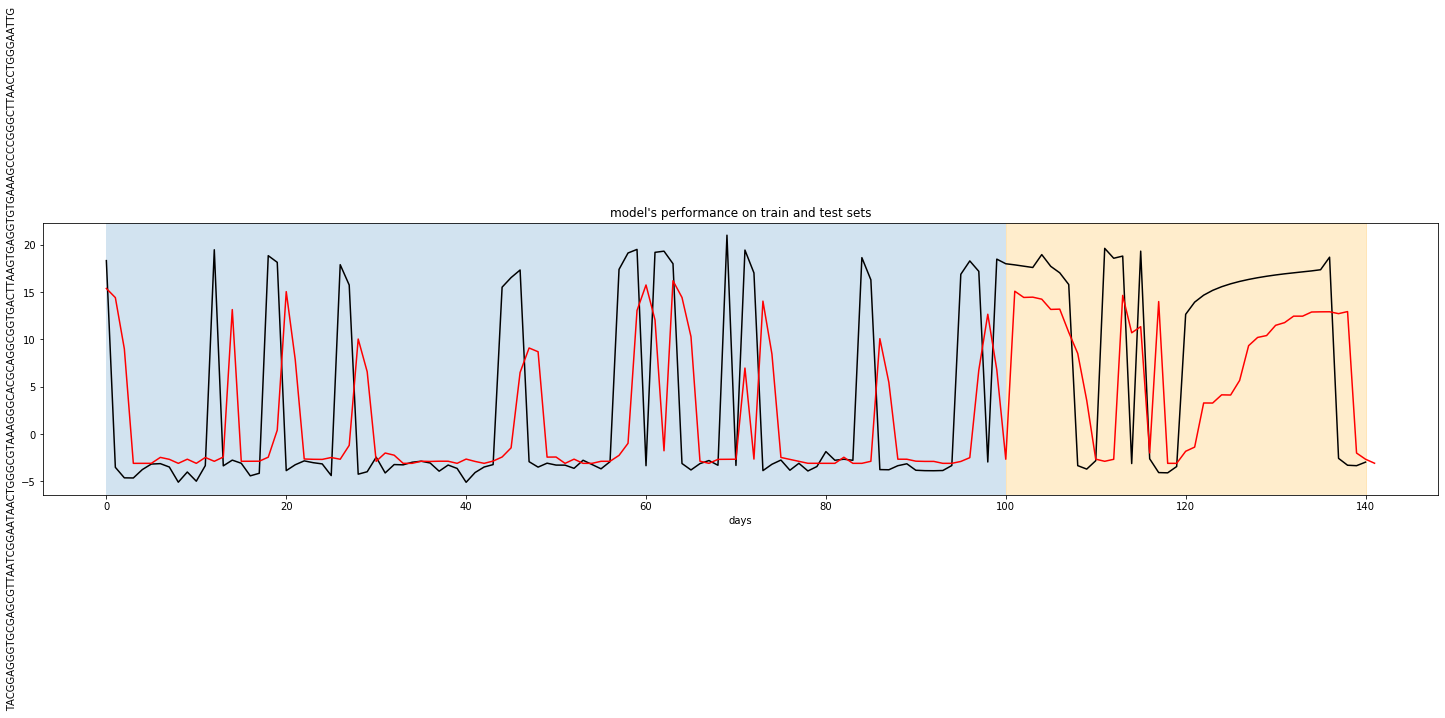

In [ ]:
true = CLR_SUPERVISED_DF.iloc[1:, 0].values
pred = np.append(prediction_train, prediction_test)

plt.figure(figsize = (25, 5))
plt.plot(true[300:], 'k')
plt.plot(pred[300:], 'r')
plt.ylabel(denom_name)
plt.xlabel('days')
plt.axvspan(0, 100, alpha=0.2)
plt.axvspan(100, 140, alpha=0.2, color='orange')
plt.title("model's performance on train and test sets")